In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv
# uncomment to get the data

df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.index.freq = 'MS'

## Holt's Linear Trend Model
---------

We will first discuss Holt's Linear Trend model to capture trends in a time series data and will add the seasonal component later 

In [4]:
# initialize the model with all the data and fit 

holt = Holt(df['Passengers'], initialization_method='legacy-heuristic')

result = holt.fit()

result.summary()



Dep. Variable:,Passengers,No. Observations:,144
Model:,Holt,SSE,164168.638
Optimized:,True,AIC,1021.592
Trend:,Additive,BIC,1033.472
Seasonal:,None,AICC,1022.206
Seasonal Periods:,None,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,18:41:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950187,alpha,True
smoothing_trend,0.0038189,beta,True


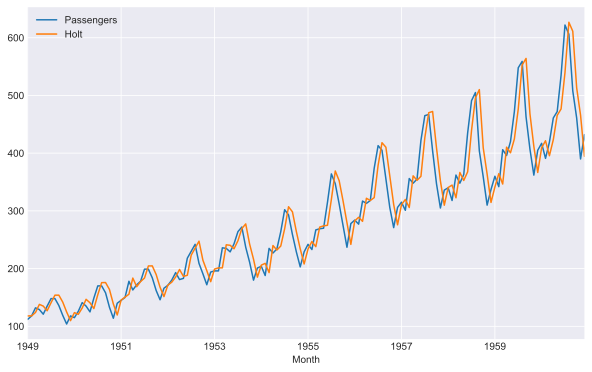

In [5]:
# add the fitted values to the df and plot

df['Holt'] = result.fittedvalues

fig, axis = plt.subplots(figsize = (10,6))

df[['Passengers', 'Holt']].plot(ax = axis)

axis.grid()

In [6]:
# train test split
N_test = 12
train, test = df[:-N_test], df[-N_test:]

# get the booleans for datetime index according to this split

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [7]:
# train the model on the training set 

holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')

result = holt.fit()

result.summary()

Dep. Variable:,Passengers,No. Observations:,132
Model:,Holt,SSE,129731.485
Optimized:,True,AIC,917.535
Trend:,Additive,BIC,929.067
Seasonal:,None,AICC,918.207
Seasonal Periods:,None,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,18:41:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9987305,alpha,True
smoothing_trend,0.0037588,beta,True


In [8]:
# get the in sample and forecasts 

df.loc[train_idx,'Holt'] = result.fittedvalues
df.loc[test_idx,'Holt'] = result.forecast(N_test)

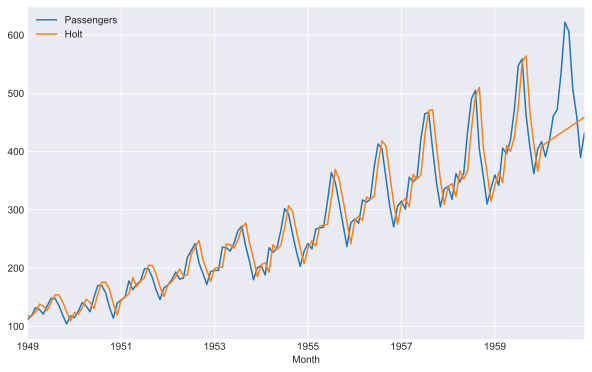

In [9]:
fig, axis = plt.subplots(figsize = (10,6))

df[['Passengers', 'Holt']].plot(ax = axis)

axis.grid()

## Holt-Winters Model
---------

Able to capture seasonaility in an additive or multiplicative manner. 

In [10]:
hw  = ExponentialSmoothing(train['Passengers'], initialization_method='legacy-heuristic', trend = 'add', seasonal = 'add', seasonal_periods=12)

result_hw = hw.fit()

result_hw.summary()


Dep. Variable:,Passengers,No. Observations:,132
Model:,ExponentialSmoothing,SSE,18545.159
Optimized:,True,AIC,684.761
Trend:,Additive,BIC,730.886
Seasonal:,Additive,AICC,690.815
Seasonal Periods:,12,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,18:42:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2518441,alpha,True
smoothing_trend,0.0390402,beta,True


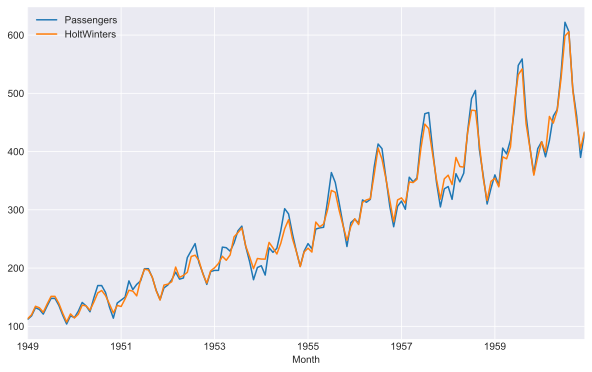

In [11]:
# include the in sample predictions and forecasts in to the df and plot 

df.loc[train_idx, 'HoltWinters'] = result_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = result_hw.forecast(N_test)

fig, axes = plt.subplots(figsize = (10,6))

df[['Passengers','HoltWinters']].plot(ax = axes)

axes.grid()



The results are encouraging!

In [12]:
# import metrics from sklearn

from sklearn.metrics import mean_absolute_error, mean_squared_error

train_rmse = mean_squared_error(train['Passengers'], result_hw.fittedvalues, squared = False)
test_rmse = mean_squared_error(test['Passengers'], result_hw.forecast(N_test), squared = False)

train_mae = mean_absolute_error(train['Passengers'], result_hw.fittedvalues)
test_mae = mean_absolute_error(test['Passengers'], result_hw.forecast(N_test))

print(f'Train and test RMSE are given by: {train_rmse:.2f}, {test_rmse:.2f}')
print(f'Train and test MAE are given by: {train_mae:.2f}, {test_mae:.2f}')


Train and test RMSE are given by: 11.85, 15.54
Train and test MAE are given by: 8.89, 10.44


Note that since the models optimize the model parameters using squared error, it makes more sense to use RMSE as the metric for model performence.

In [13]:
# Next we will try to multiplicate seasonal component model which we expect to perform better as the cycles amplitudes increase as the trend increases

hw_m  = ExponentialSmoothing(train['Passengers'], initialization_method='legacy-heuristic', trend = 'add', seasonal = 'mul', seasonal_periods=12)

result_hw_m = hw_m.fit()

result_hw_m.summary()

Dep. Variable:,Passengers,No. Observations:,132
Model:,ExponentialSmoothing,SSE,13609.516
Optimized:,True,AIC,643.915
Trend:,Additive,BIC,690.040
Seasonal:,Multiplicative,AICC,649.968
Seasonal Periods:,12,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,18:42:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3188047,alpha,True
smoothing_trend,0.0413771,beta,True


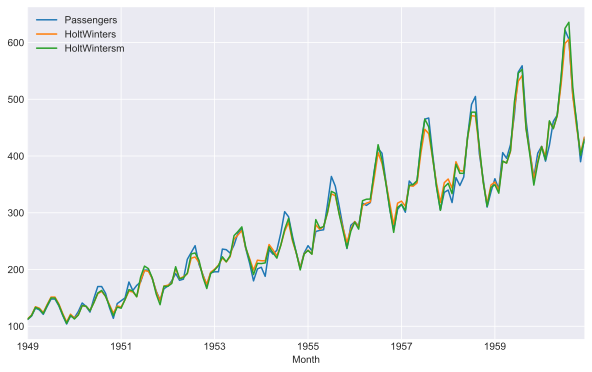

In [14]:
# include the in sample predictions and forecasts in to the df and plot 

df.loc[train_idx, 'HoltWintersm'] = result_hw_m.fittedvalues
df.loc[test_idx, 'HoltWintersm'] = result_hw_m.forecast(N_test)

fig, axes = plt.subplots(figsize = (10,6))

df[['Passengers','HoltWinters','HoltWintersm']].plot(ax = axes)

axes.grid()

In [15]:
train_rmse = mean_squared_error(train['Passengers'], result_hw_m.fittedvalues, squared = False)
test_rmse = mean_squared_error(test['Passengers'], result_hw_m.forecast(N_test), squared = False)

train_mae = mean_absolute_error(train['Passengers'], result_hw_m.fittedvalues)
test_mae = mean_absolute_error(test['Passengers'], result_hw_m.forecast(N_test))

print(f'Train and test RMSE are given by: {train_rmse:.2f}, {test_rmse:.2f}')
print(f'Train and test MAE are given by: {train_mae:.2f}, {test_mae:.2f}')

Train and test RMSE are given by: 10.15, 16.54
Train and test MAE are given by: 7.55, 10.68


Train errors are reduced but the test errors are increased if you use a multiplicative seasonal component! Model performence do not increased, so we should prefer the previous model as far as this data is concerned. 

In [16]:
# Finall lets choose both components multiplicative 

hw_mm  = ExponentialSmoothing(train['Passengers'], initialization_method='legacy-heuristic', trend = 'mul', seasonal = 'mul', seasonal_periods=12)

result_hw_mm = hw_mm.fit()

result_hw_mm.summary()

Dep. Variable:,Passengers,No. Observations:,132
Model:,ExponentialSmoothing,SSE,12903.830
Optimized:,True,AIC,636.887
Trend:,Multiplicative,BIC,683.012
Seasonal:,Multiplicative,AICC,642.940
Seasonal Periods:,12,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,18:46:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3092260,alpha,True
smoothing_trend,0.0041014,beta,True


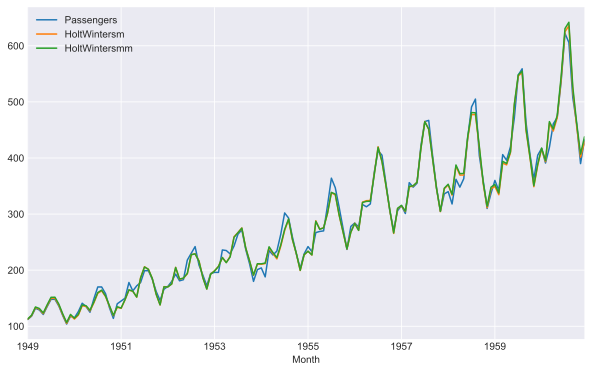

In [17]:
df.loc[train_idx, 'HoltWintersmm'] = result_hw_mm.fittedvalues
df.loc[test_idx, 'HoltWintersmm'] = result_hw_mm.forecast(N_test)

fig, axes = plt.subplots(figsize = (10,6))

df[['Passengers','HoltWintersm','HoltWintersmm']].plot(ax = axes)

axes.grid()

In [18]:
train_rmse = mean_squared_error(train['Passengers'], result_hw_mm.fittedvalues, squared = False)
test_rmse = mean_squared_error(test['Passengers'], result_hw_mm.forecast(N_test), squared = False)

train_mae = mean_absolute_error(train['Passengers'], result_hw_mm.fittedvalues)
test_mae = mean_absolute_error(test['Passengers'], result_hw_mm.forecast(N_test))

print(f'Train and test RMSE are given by: {train_rmse:.2f}, {test_rmse:.2f}')
print(f'Train and test MAE are given by: {train_mae:.2f}, {test_mae:.2f}')

Train and test RMSE are given by: 9.89, 19.10
Train and test MAE are given by: 7.41, 13.45


Test error has gone up, while training errors has gone down. Therefore when we choose both components multiplicative we encounter with an over-fitting issue. 